# Matrix completion via nuclear norm minimization (python 3.4)
In this notebook, we study the performance of some algorithms used to complete low-rank matrices where only a small fraction of the entries have been observed.

To vizualize performances of these algorithms we use real-world pictures as matrices. First we need to check that real-world picture are almost low-rank matrices. Then we will use a SDP formulation of the nuclear norm minimization procedure and then we will turn to a forward backward splitting algorithm which uses the proximal operator of the nuclear norm.

**package**:
    1. PIL if one wants to use its own images
    2. CVXOPT and CVXPY for solving a SDP

$\newcommand{\eps}{\varepsilon}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\bA}{\mathbb{A}}$
$\newcommand{\bS}{\mathbb{S}}$

$\newcommand{\cO}{\mathcal{O}}$
$\newcommand{\cA}{\mathcal{A}}$
$\newcommand{\cC}{\mathcal{C}}$
$\newcommand{\cS}{\mathcal{S}}$

$\newcommand{\1}{{\rm 1}\kern-0.24em{\rm I}}$
$\newcommand{\inr}[1]{\bigl< #1 \bigr>}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\DeclareMathOperator*{\argmin}{argmin}$

## Load a picture 
Default pictures are available in scipy or any personal picture will do as well.

In [1]:
from scipy import misc
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

%matplotlib inline

#### scipy pictures

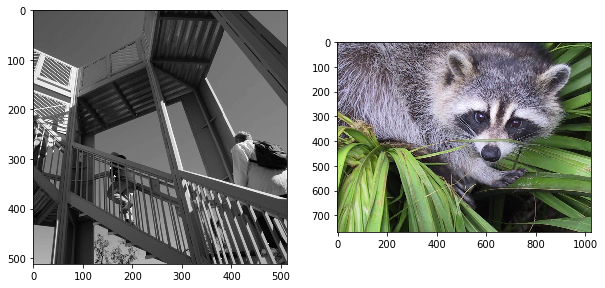

In [2]:
ascent = misc.ascent()
face = misc.face()

plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(ascent, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(face)


#### personnal pictures
Personnal pictures can be loaded via the library PIL. Loaded colored images has a PIL type which is not a classical matrix (it is a list of triples). So for our study we will only consider one slice of this list.

In [3]:
ensae = Image.open("ensae.png")

In [4]:
print(ensae.size, type(ensae))

(790, 634) <class 'PIL.PngImagePlugin.PngImageFile'>


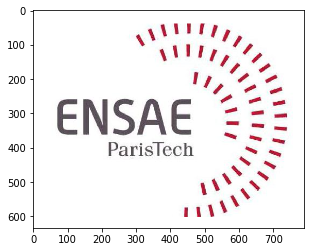

In [5]:
plt.imshow(ensae)

In [6]:
ensae_np = np.array(ensae)
print(ensae_np.shape)
print("colored images are not simple 2d arrays!")

(634, 790, 4)
colored images are not simple 2d arrays!


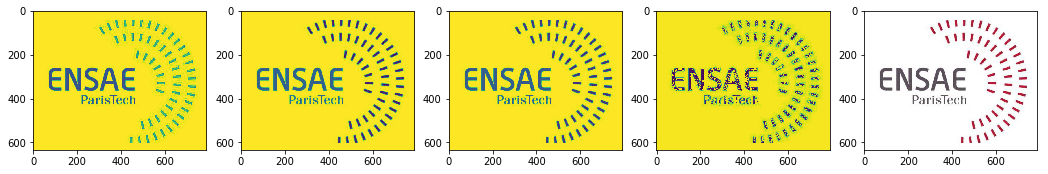

In [7]:
ensae = np.array(ensae)
plt.figure(figsize = (18,10))
plt.subplot(1,5,1)
plt.imshow(ensae[:,:,0])
plt.subplot(1,5,2)
plt.imshow(ensae[:,:,1])
plt.subplot(1,5,3)
plt.imshow(ensae[:,:,2])
plt.subplot(1,5,4)
plt.imshow(ensae[:,:,0] + ensae[:,:,1] + ensae[:,:,2] + ensae[:,:,3])#, cmap=plt.cm.gray)
plt.subplot(1,5,5)
plt.imshow(ensae_np)

In [8]:
ensae = ensae_np[:,:,0]
face = face[:,:,0]

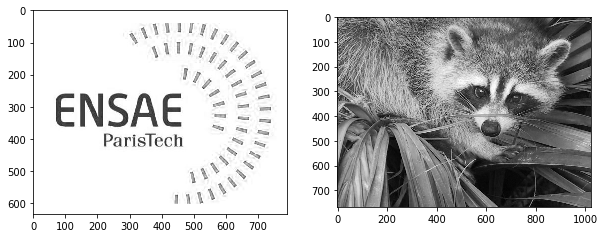

In [9]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(ensae, cmap=plt.cm.gray)#, interpolation="none")
plt.subplot(1,2,2)
plt.imshow(face, cmap=plt.cm.gray)#, interpolation="none")

## Pictures as np.array
Pictures loaded in python can now be seen as np.array

In [10]:
print(type(ensae), type(face))
print(ensae.shape, face.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(634, 790) (768, 1024)


In [11]:
face[0:10, 0:10]

array([[121, 138, 153, 155, 155, 158, 159, 156, 147, 137],
       [ 89, 110, 130, 137, 141, 148, 152, 151, 164, 154],
       [ 73,  94, 115, 123, 127, 131, 132, 129, 139, 135],
       [ 81,  97, 113, 120, 125, 126, 120, 111, 101, 101],
       [103, 113, 123, 132, 142, 147, 140, 127, 109, 101],
       [124, 128, 131, 137, 150, 163, 163, 155, 136, 119],
       [109, 110, 108, 108, 122, 144, 159, 163, 155, 143],
       [ 68,  70,  67,  66,  81, 112, 142, 157, 170, 170],
       [102,  94,  85,  80,  74,  80, 106, 136, 166, 179],
       [123, 116, 108,  97,  83,  75,  82,  95, 135, 158]], dtype=uint8)

In [12]:
ensae[0:10, 0:10]

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

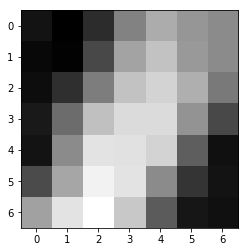

In [13]:
plt.imshow(face[123:130, 123:130], cmap=plt.cm.gray, interpolation="none")

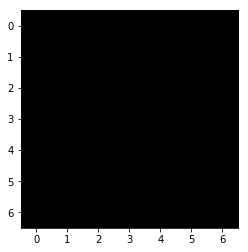

In [14]:
plt.imshow(ensae[123:130, 123:130], cmap=plt.cm.gray, interpolation="none")

## Real-world images are "almost" low-rank matrices!
We recall that any matrix $A\in\R^{u\times v}$ has a singular value decomposition (SVD): there exists $U\in\cO(u)$ and $V\in\cO(v)$ two orthogonal matrices such that
$$
A=U S V
$$
where $S= {\rm diag}(\sigma_A)\in\R^{u\times v}$ and $\sigma_A=(\sigma_1,\ldots,\sigma_{u\wedge v})$ is the spectrum of $A$. One can get this decomposition via numpy:

> U, s, V = numpy.linalg.svd(A)

returns the SVD of $A$. Note that $s$  is the vector of all singular values ordered in a decreasing way; to get the diagonal matrix $S$ one can use **np.diag(s)**. In this case,  **np.dot(U, np.dot(S, V))}** is close to $A$.

> S = np.diag(s)

> np.dot(U, np.dot(S, V))

**Note:** np.diag(s) return a square matrix whereas we need a rectangular $u\times v$ matrix. So to make the exposition simple, we will work only with square matrix (i.e. $u=v$).

In [15]:
from numpy.linalg import svd

In [16]:
face = face[0:768, 0:768] # to get a square matrix
U, s, V = svd(face)

In [17]:
S = np.diag(s)
FACE = np.dot(U, np.dot(S, V))
print(np.allclose(face, FACE))
print(np.linalg.norm(FACE-face, 2))

True
2.9197035010728334e-10


(-5, 55)

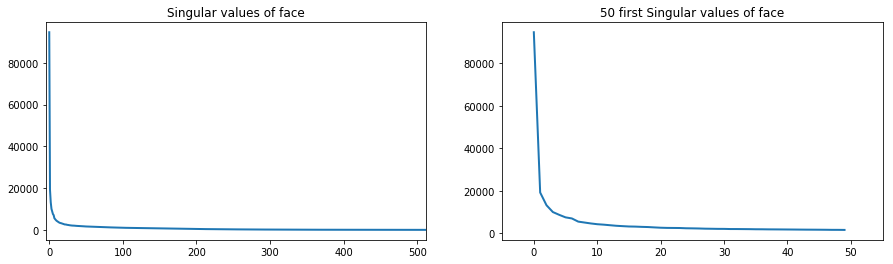

In [18]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(s, lw=2)
plt.title("Singular values of face")
plt.xlim([-5, 512])
plt.subplot(1,2,2)
plt.plot(s[0:50], lw=2)
plt.title("50 first Singular values of face")
plt.xlim([-5, 55])

(-5, 55)

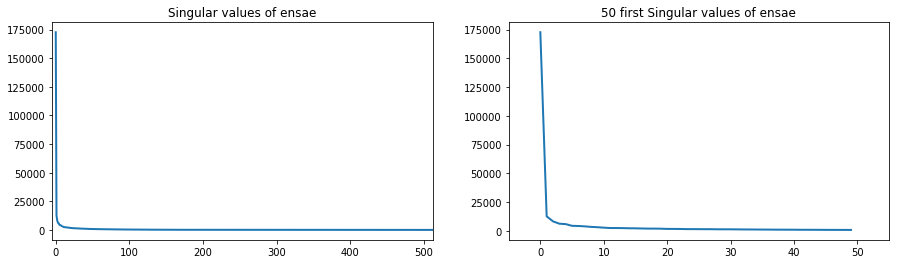

In [19]:
U, s, V = svd(ensae)
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(s,  lw=2)
plt.title("Singular values of ensae")
plt.xlim([-5, 512])
plt.subplot(1,2,2)
plt.plot(s[0:50], lw=2)
plt.title("50 first Singular values of ensae")
plt.xlim([-5, 55])

**Conclusion: images are amazingly "almost" low rank!**

Let us see if one truncates the SVD of an image (by setting many small singular values to zero) one can recover the picture.

## Images with truncated svd
Truncated SVD may performed via the *svds* scipy method [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) or via sklearn [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html). Below we just use the numpy *svd* method and keep only the first singular value putting the other to zero.

In [20]:
def truncated_svd(image = face, rank = 50):
    U, s, V = svd(image)
    n = s.size
    s[rank-n:-1] = 0
    return U, s, V  

In [21]:
image, rank = face, 50
U, sr, V = truncated_svd(image, rank)
S_r = np.diag(sr)
face_r = np.dot(U, np.dot(S_r, V))

Text(0.5, 1.0, 'Singular values of face')

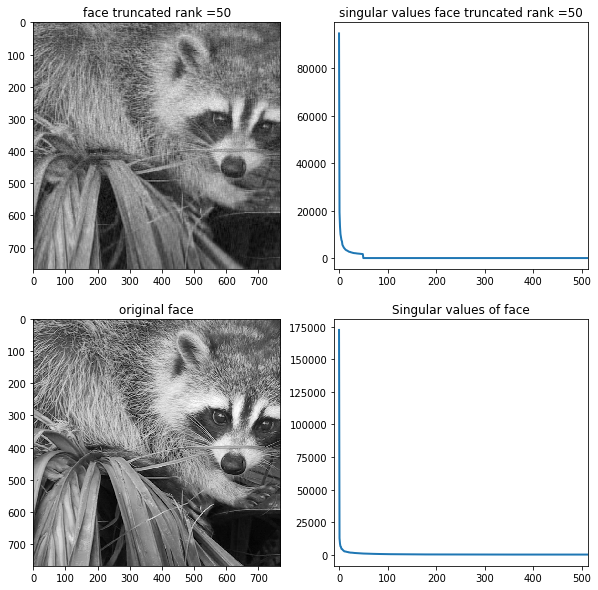

In [22]:
plt.figure(figsize = (10, 10))
plt.subplot(2,2,1)
plt.imshow(face_r, cmap=plt.cm.gray, interpolation="none")
titre = 'face truncated rank ={}'.format(rank)
plt.title(titre)
plt.subplot(2,2,2)
plt.plot(sr, lw = 2)
plt.xlim([-10, 512])
titre = 'singular values face truncated rank ={}'.format(rank)
plt.title(titre)
plt.subplot(2, 2, 3)
plt.imshow(face, cmap=plt.cm.gray)
plt.title("original face")
plt.subplot(2,2,4)
plt.plot(s, lw=2)
plt.xlim([-10, 512])
plt.title("Singular values of face")

## Construction of a dataset using a mask
We remove randomly some entries from the matrix associated to an image using Bernoulli variables; this is what is called the mask. We can formalize it as a function
$$
P_\Omega : \left\{
\begin{array}{ccc}
\R^{u\times v} & \to & \R^{u\times v}\\
A & \to & P_\Omega(A)
\end{array}
\right. \mbox{ where } (P_\Omega(A))_{ij} = \left\{
\begin{array}{cc}
A_{ij} & \mbox{ if } (i,j)\in\Omega\\
0 & \mbox{ otherwise}
\end{array}
\right.
$$and $\Omega\subset\{1,\ldots,u\}\times \{1,\ldots,v\}$ is the set of indices of the observed entries. In the following, this set is constructed randomly using **selectors** (i.e. Bernoulli variables): every entry is selected with some probability called *proportion* below. We look at $P_\Omega(A)$ as a dataset of the form **{(user, item, grade)}** where $(user, item)\in\Omega$ and *grade* is the value of the pixel at (user, item) of the image. This is the classical way datasets are in *collaborative filtering* or *recommandation system*.


In [23]:
def mask(u, v, proportion = 0.2):
    mat_mask = np.random.binomial(1, proportion, size =  (u, v))
    print("We observe {} per cent of the entries of a {}*{} matrix".format(100 * mat_mask.mean(),u, v))
    return mat_mask

In [24]:
image = face
proportion = 0.2
u, v = image.shape
mat_mask = mask(u, v, proportion)
image_masked = np.multiply(mat_mask, image)

We observe 19.900004069010414 per cent of the entries of a 768*768 matrix


Text(0.5, 1.0, 'Observed entries; black = unobserved')

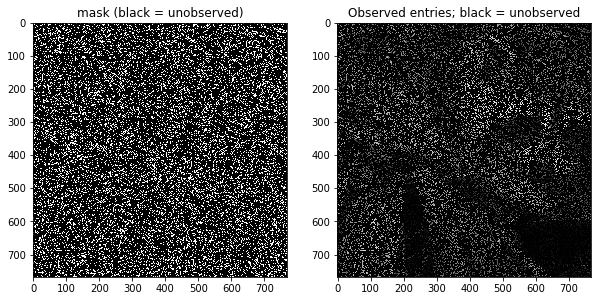

In [25]:
plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(mat_mask, cmap=plt.cm.gray); plt.title("mask (black = unobserved)")
plt.subplot(1, 2, 2)
plt.imshow(image_masked, cmap=plt.cm.gray); plt.title("Observed entries; black = unobserved")

In [26]:
rank = 30
image = face
U, sr, V = truncated_svd(image, rank)
S_r = np.diag(sr)
image_r = np.dot(U, np.dot(S_r, V))
proportion = 0.2
u, v = image_r.shape
mat_mask = mask(u, v, proportion)

We observe 20.04174126519097 per cent of the entries of a 768*768 matrix


**Conclusion:** now that we have observed some entries of a low-rank matrix, one can tries to complete it via some "matrix completion algorithms". The nuclear norm will play a central role in the following procedures.

# Matrice completion via nuclear norm minimization

A natural convex relaxation approach of the rank minimization procedure is the nuclear norm minimization procedure:


$$
\hat A \in \argmin_{A\in \R^{u\times v}}\big(\norm{A}_{S_1} : \cA(A) = y\big).\tag{NM}
$$
where $\cA(A) = (\inr{A, X_i})_{i=1}^m$,  $y=\cA(A^*)$, $A^*$ is the low-rank matrix that we want to reconstruct and $\norm{\cdot}_{S_1}$ is the nuclear norm (that is the sum of singular values).


It is possible to recast (NM) as a SDP problem: 

$$
\left(
\begin{array}{c}
\hat X\\
\hat Y\\
\hat Z
\end{array}
\right)\in\argmin_{X\in\R^{u\times v}, Y\in\cS^u, Z\in\cS^v} {\rm Tr}(Y) + {\rm Tr}(Z) \mbox{ tel que } 
\begin{array}{l}
\cA(X) = y\\
\left[
\begin{array}{cc}
Y & X\\
X^\top & Z
\end{array}
\right]\succeq 0
\end{array}\tag{SDP}
$$

**Theorem**

The two problems (NM) and (SDP) are equivalent :

1)  if $\hat A$ is a  solution to (NM) then  $(\hat A, \hat Y, \hat Z)^\top$ is a solution to (SDP) for some $\hat Y$ et $\hat Z$,

2) if $(\hat X, \hat Y, \hat Z)^\top$ is solution to (SDP) then $\hat X$ is solution to (NM).


#### Thanks to cvxpy we can directly ask to solve the nuclear norm minimlization problem (NM) directly without having to write it in its SDP formulation. This is what we are doing below.

In [27]:
from cvxpy import *
print(installed_solvers())

['CVXOPT', 'GLPK_MI', 'SCS', 'ECOS', 'ECOS_BB', 'GLPK', 'OSQP']


**Note**: Only the solvers 'SCS' or 'CVXOPT' can solve SDP problems (cf. [cvxpy 'Choosing a solver chapter](http://www.cvxpy.org/en/latest/tutorial/advanced/)). For the time being, only SCS works on my machine for this problem. Using 'CVXOPT' always leads to a *dead kernel* after a minute of computation (don't know why?).

In [28]:
def nuclear_norm_mini(mat_mask, image):
    u, v = image.shape
    A = Variable((u, v))
    obj = Minimize(norm(A, 'nuc'))
    constraints = [multiply(mat_mask, A) == multiply(mat_mask, np.array(image))]
    prob = Problem(obj, constraints)
    prob.solve(solver=SCS)
    if prob.status != 'optimal':
        print('CVXPY failed to reach optimal value')
    return A.value

In [29]:
rank = 30
size = 180
image = face[0:size, 0:size]
U, sr, V = truncated_svd(image, rank)
S_r = np.diag(sr)
image_r = np.dot(U, np.dot(S_r, V))
proportion = 0.5
u, v = image_r.shape
mat_mask = mask(u, v, proportion)

We observe 50.16975308641975 per cent of the entries of a 180*180 matrix


In [30]:
now_0 = time.time()
A = nuclear_norm_mini(mat_mask, image_r)
print("{} seconds".format(time.time() - now_0))

177.84628772735596 seconds


Text(0.5, 1.0, 'Image reconstructed via nuclear norm minimization')

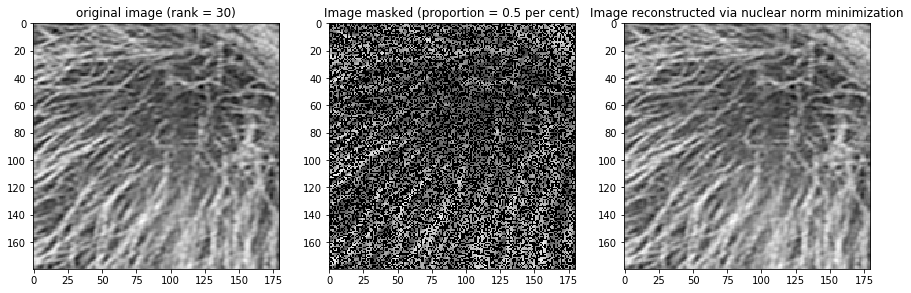

In [31]:
plt.figure(figsize = (15, 10))
plt.subplot(1,3,1)
plt.imshow(image_r, cmap=plt.cm.gray)
plt.title("original image (rank = {})".format(rank))
plt.subplot(1,3,2)
plt.imshow(np.multiply(mat_mask, image_r), cmap=plt.cm.gray)
plt.title("Image masked (proportion = {} per cent)".format(proportion))
plt.subplot(1,3,3)
plt.imshow(A, cmap=plt.cm.gray)
plt.title("Image reconstructed via nuclear norm minimization")

In [32]:
def recons_plot(image, size=100, rank=30, proportion=0.2):
    U, sr, V = truncated_svd(image[0:size, 0:size], rank)
    S_r = np.diag(sr)
    image_r = np.dot(U, np.dot(S_r, V))
    u, v = image_r.shape
    mat_mask = mask(u, v, proportion)
    now_0 = time.time()
    A = nuclear_norm_mini(mat_mask, image_r)
    print("{} seconds for nulcear norm minimization".format(time.time() - now_0))
    plt.figure(figsize = (15, 10))
    plt.subplot(1,3,1)
    plt.imshow(image_r, cmap=plt.cm.gray)
    plt.title("original image (rank = {})".format(rank))
    plt.subplot(1,3,2)
    plt.imshow(np.multiply(mat_mask, image_r), cmap=plt.cm.gray)
    plt.title("Image masked (proportion = {} per cent)".format(proportion))
    plt.subplot(1,3,3)
    plt.imshow(A, cmap=plt.cm.gray)
    plt.title("Image reconstructed via nuclear norm minimization")    

We observe 40.8 per cent of the entries of a 50*50 matrix
48.84358835220337 seconds for nulcear norm minimization


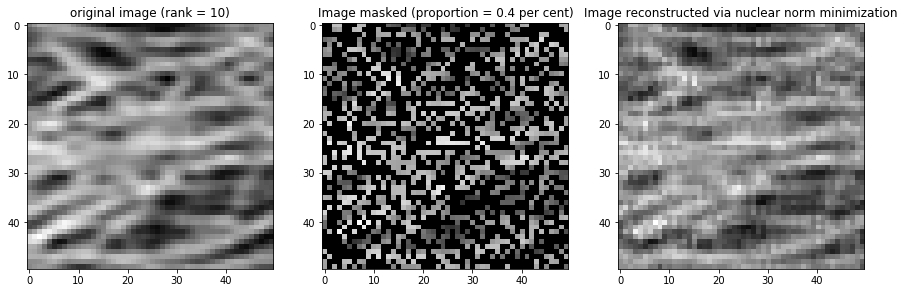

In [33]:
recons_plot(face, size=50, rank=10, proportion=0.4)

We observe 39.4 per cent of the entries of a 100*100 matrix
45.99575138092041 seconds for nulcear norm minimization
We observe 39.7 per cent of the entries of a 100*100 matrix
46.50645565986633 seconds for nulcear norm minimization
We observe 40.22 per cent of the entries of a 100*100 matrix
305.09179496765137 seconds for nulcear norm minimization
We observe 40.11 per cent of the entries of a 100*100 matrix
26.174347400665283 seconds for nulcear norm minimization


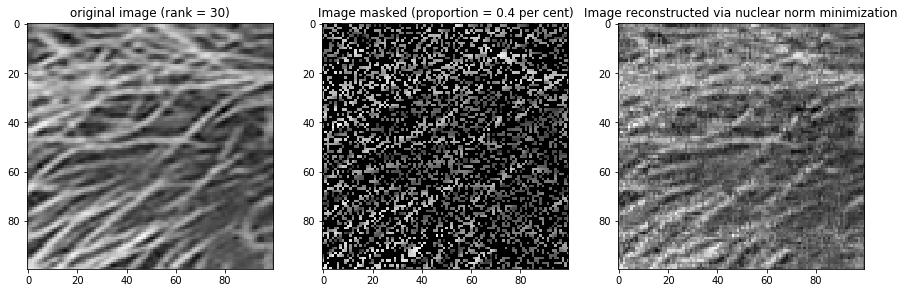

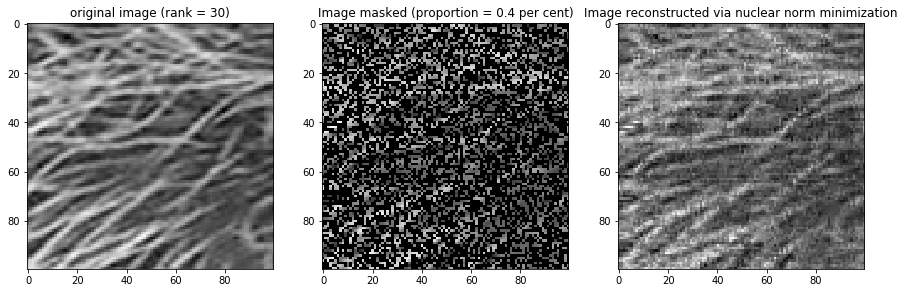

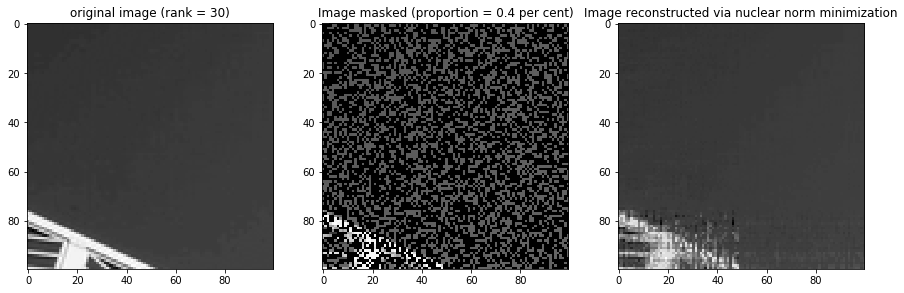

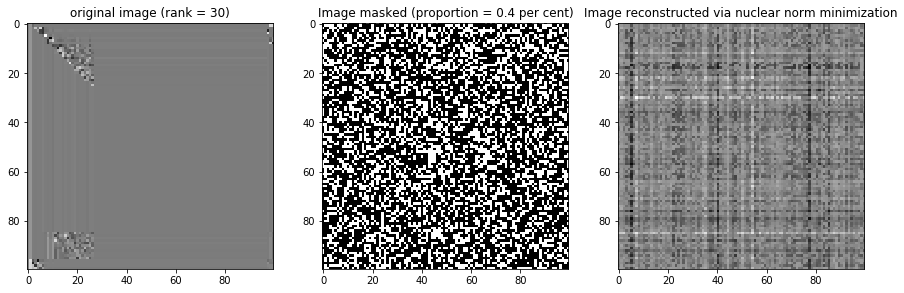

In [34]:
images = [face, face, ascent, ensae]
for image in images:
    recons_plot(image, size=100, rank=30, proportion=0.4)

**Conclusion**: 

1) Nuclear norm minimization via cvxpy works well up to matrices of size $200\times200$. 

2) It is harder to reconstruct matrices that are sparse and low rank. This last observation is known in theory since matrice completion works well only when the singular vectors (of the matrix to be reconstructed) are incoherent with the canonical basis. This is not the case of sparse + low-rank matrices. 

## Matrix Completion via Proximal gradient descent
Given the data $P_\Omega(A^*)$, one may try to recover $A^*$ via the least-squares regularization procedure:

$$
\hat A \in\argmin_{A\in\R^{u\times v}} \frac{1}{2}\norm{P_\Omega(A^*) - P_\Omega(A)}_{S_2}^2 + \lambda \norm{A}_{S_1}
$$where $\lambda$ is a regularization parameter.

A way to implement this procedure is to perform a proximal gradient descent: 

$$
A^{k+1} = {\rm prox}_{\gamma_k \lambda\norm{\cdot}_{S_1}}\big(A^k - \gamma_k \nabla F(A^k)\big) \mbox{ where } F(A) = \frac{1}{2}\norm{P_\Omega(A^*) - P_\Omega(A)}_{S_2}^2.
$$
One can see that $\nabla F(A) =  (P_\Omega(A)-P_\Omega(A^*))$ and that the proximal operator of $\gamma_k \lambda\norm{\cdot}_{S_1}$ is the **spectral soft thresholding operator** $S_\mu$ -- for $\mu = \gamma_k\lambda$:

$$
{\rm prox}_{\mu\norm{\cdot}_{S_1}}(A) = S_\mu(A) = US_{\mu} V 
$$
where a SVD of $A$ is $A = USV$ and $S_\mu = {\rm diag}((\sigma_1-\mu)_+, (\sigma_2-\mu)_+, \cdots)$ is the $u\times v$ diagonal matrix of the soft threshold of the spectrum of $A$.

#### Spectral soft-thresholding operator

In [35]:
def spectral_soft_thresh(A, mu):
    U, s, V = svd(A)
    s_mu = (s - mu) * (s > mu)
    return np.dot(U, np.dot(np.diag(s_mu), V))

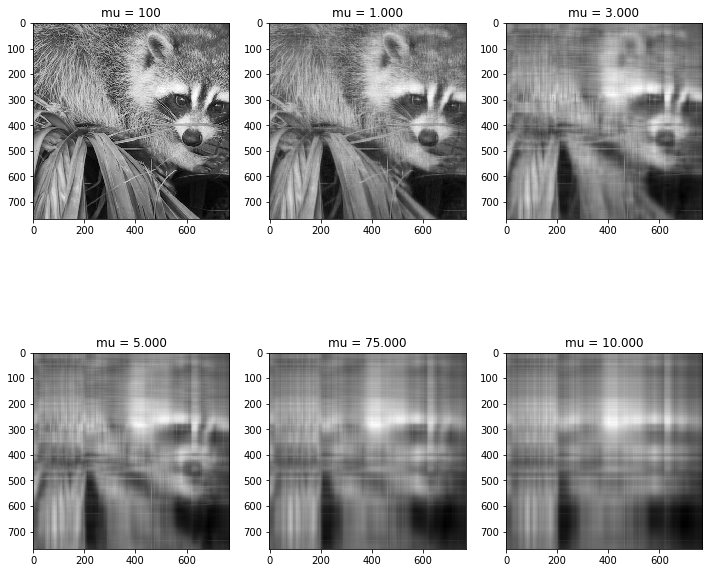

In [36]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 3, 1)
image = spectral_soft_thresh(face, 100)
plt.imshow(image, cmap = plt.cm.gray)
plt.title("mu = 100")
plt.subplot(2, 3, 2)
image = spectral_soft_thresh(face, 1000)
plt.imshow(image, cmap = plt.cm.gray)
plt.title("mu = 1.000")
plt.subplot(2, 3, 3)
image = spectral_soft_thresh(face, 3000)
plt.imshow(image, cmap = plt.cm.gray)
plt.title("mu = 3.000")
plt.subplot(2, 3, 4)
image = spectral_soft_thresh(face, 5000)
plt.imshow(image, cmap = plt.cm.gray)
plt.title("mu = 5.000")
plt.subplot(2, 3, 5)
image = spectral_soft_thresh(face, 7500)
plt.imshow(image, cmap = plt.cm.gray)
plt.title("mu = 75.000")
plt.subplot(2, 3, 6)
image = spectral_soft_thresh(face, 10000)
plt.imshow(image, cmap = plt.cm.gray)
plt.title("mu = 10.000")
plt.tight_layout()

**We define the proximal gradient descent** for $\gamma_k=1$ that is:

$$
A^{k+1} = S_\lambda(P_{\Omega^c}(A^k) + P_\Omega(A^*))
$$

In [37]:
def prox_grad_descent(image, mat_mask, mu, n_iter=100, verbose = False):
    image_masked = np.multiply(image, mat_mask)
    list_errors = []
    A = np.zeros(image_masked.shape)
    for i in range(n_iter + 1):
        A = spectral_soft_thresh(A * (1 - mat_mask) + image_masked, mu)
        err = np.linalg.norm(A - image, 2) / np.linalg.norm(image, 2)
        list_errors.append(err)
        if i % 20 == 0 and verbose == True:
            print("iteration = {}; error = {}".format(i, err))
            plt.figure
            plt.imshow(A, cmap = plt.cm.gray)
            plt.show()
    return A, list_errors

We observe 20.029195149739586 per cent of the entries of a 768*768 matrix
iteration = 0; error = 0.8022591253582587


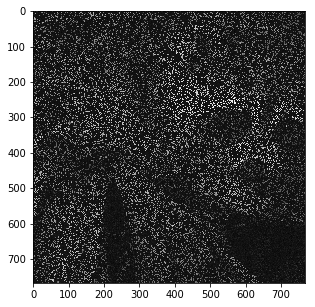

iteration = 20; error = 0.5264380991417714


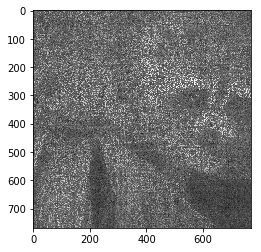

iteration = 40; error = 0.32322947075825054


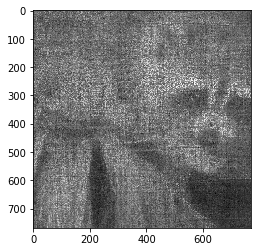

iteration = 60; error = 0.17990448026728087


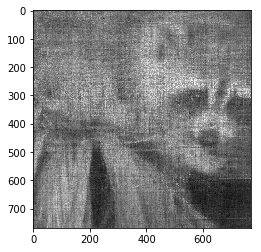

iteration = 80; error = 0.09543983284194814


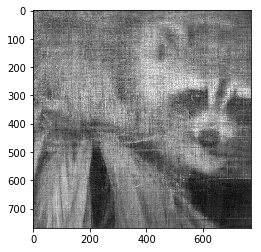

iteration = 100; error = 0.0563600916186307


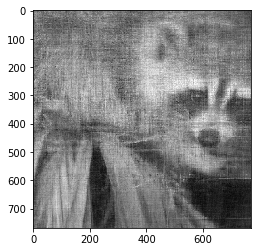

In [38]:
mu = 200
size = 100
proportion = 0.2

image = face#[0:size, 0:size]
u, v = image.shape
mat_mask = mask(u, v, proportion)

plt.figure(figsize=(5, 5))
image_reconstructed, list_errors = prox_grad_descent(image, mat_mask, mu, verbose=True)

### Evolution of relative error along the descent

Text(0.5, 1.0, 'Evolution of the relative error along the projected descent')

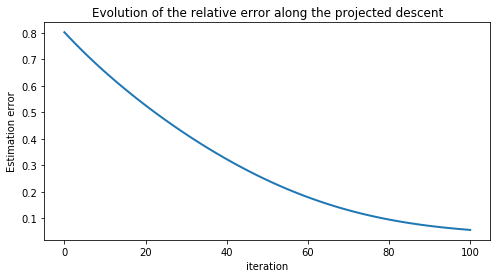

In [39]:
plt.figure(figsize=(8, 4))
plt.plot(list_errors, lw=2)
plt.xlabel("iteration")
plt.ylabel("Estimation error")
plt.title("Evolution of the relative error along the projected descent")

In [40]:
rank = np.linalg.matrix_rank(image_reconstructed)
U, sr, V = truncated_svd(image, rank)
S_r = np.diag(sr)
image_r = np.dot(U, np.dot(S_r, V))

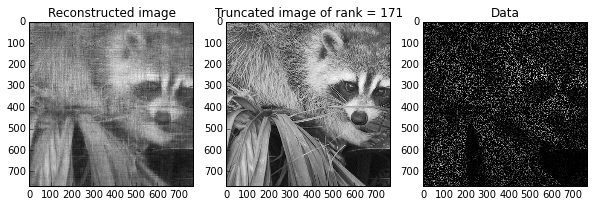

In [56]:
plt.figure(figsize = (10, 10))
#plt.rcParams['figure.figsize'] = 6., 4.
plt.subplot(1, 3, 1)
plt.imshow(image_reconstructed, cmap = plt.cm.gray)
plt.title("Reconstructed image")
plt.subplot(1, 3, 2)
plt.imshow(image_r, cmap = plt.cm.gray)
plt.title("Truncated image of rank = {}".format(rank))
plt.subplot(1, 3, 3)
plt.imshow(np.multiply(image, mat_mask), cmap = plt.cm.gray)
plt.title("Data")

## Choice of the regularization parameter $\lambda$ via cross-validation
Procedure $$\hat A \in\argmin \frac{1}{2}\norm{P_\Omega(A^*) - P_\Omega(A)}_{S_2}^2 + \lambda \norm{A}_{S_1}$$ 
depends on the regularization parameter $\lambda$. In the proximal gradient descent previously introduced to implement this procedure, the regularization parameter is exactly the threshold parameter of the spectral soft thresholding operator: $\lambda = \mu$. From a theoretical point one view we should take this parameter of the order of

$$
\sqrt{\frac{u+v}{|\Omega|}}
$$
where $|\Omega|$ is the number of observations. In the following we learn the value of this parameter via cross-validation.

In [57]:
def mask_train_test(u,v, V, proportion = 0.2, ratio_train_test = 0.9):
    main_train = np.random.binomial(1, proportion, size =  (u, v))
    list_train_test = []
    for i in range(V):
        train_test = np.random.binomial(1, ratio_train_test , size =  (u, v))
        test = np.multiply(main_train, train_test)
        train = main_train - test
        list_train_test.append([train, test])
    return list_train_test

In [58]:
def cv_mu(image, mu, V,  proportion = 0.2, ratio_train_test = 0.9):
    u, v = image.shape
    error = 0
    list_train_test = mask_train_test(u, v, V,  proportion, ratio_train_test)
    for ele in list_train_test:
        train, test = ele[0], ele[1]
        image_reconstructed, _ = prox_grad_descent(image, train, mu)
        image_reconstructed_masked_test = np.multiply(image_reconstructed, test)
        image_masked_test = np.multiply(image, test)
        error = error + np.linalg.norm(image_reconstructed_masked_test - image_masked_test, 'fro')
    return error/V    

In [59]:
def cv_mu_list(list_mu, image, V = 3, proportion = 0.2, ratio_train_test = 0.9):
    list_errors = []
    for mu in list_mu:
        list_errors.append(cv_mu(image, mu, V, proportion, ratio_train_test))
    return list_errors       

In [61]:
#list_mu = [200, 1000]
list_mu = np.logspace(2, 3, 30)
size = 300
proportion = 0.3
ratio_train_test = 0.9
image = face#[0:size, 0:size]
V = 5

list_errors = cv_mu_list(list_mu, image, V, proportion, ratio_train_test)

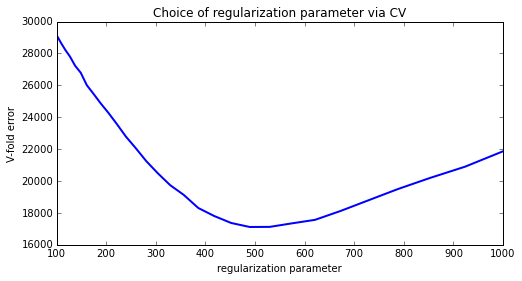

In [359]:
plt.figure(figsize=(8, 4))
plt.plot(list_mu, list_errors, lw=2)
plt.xlabel("regularization parameter")
plt.ylabel("V-fold error")
plt.title("Choice of regularization parameter via CV")
#plt.savefig("gaussian_100.png",bbox_inches='tight')

In [351]:
mu_best = list_mu[np.argmin(list_errors)]
print('the best regularization parameter is {}'.format(mu_best))

the best regularization parameter is 239.502661999


We observe 30.1 per cent of the entries of a 100*100 matrix


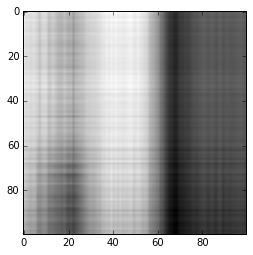

In [354]:
u, v = image.shape
mat_mask = mask(u, v, proportion)
image_reconstructed, _ = prox_grad_descent(image, mat_mask, mu_best)
plt.imshow(image_reconstructed, cmap = plt.cm.gray)